# The Union components
This tutorial is the first in a series showing how the Union components are used. This notebook focuses on setting up material definitions that are used to provide scattering physics to geometries. There are several kinds of Union components, and they need to be used in conjunction with one another to function.
- Process components: Describe individual scattering phenomena, such as incoherent, powder, single crystal scattering
- Make_material component: Joins several processes into a material definition
- Geometry components: Describe geometry, each is assigned a material definition
- Union logger components: Records information for each scattering event and plots it
- Union abs logger components: Records information for each absorption event and plots it
- Union conditional components: Modifies a logger or abs logger so it only records when certain final condition met
- Union master component: Performs simulation described by previous Union components

In this notebook we will focus on setting up materials using process components and the *Union_make_material* component, but the Union components can not work individually, so it will also be necessary to add a geometry and the *Union_master*. First we import McStasScript and create a new instrument object.

In case of any issues with running the tutorial notebooks there is troubleshooting at the end of this notebook.

In [1]:
import mcstasscript as ms

In [2]:
instrument = ms.McStas_instr("python_tutorial", input_path="run_folder")

### Process components
In this notebook we will focus on exploring how to build different physical descriptions of materials, and checking that they behave as expected. We start by looking at the process component for incoherent scattering, Incoherent_process.

In [3]:
instrument.show_components("Work directory")

No components added to instrument object yet.


In [4]:
instrument.component_help("Incoherent_process")

 ___ Help Incoherent_process ________________________________________________________
|optional parameter|required parameter|default value|user specified value|
sigma = 5.08 [barns] // Incoherent scattering cross section
f_QE = 0.0 [1] // Fraction of quasielastic scattering (rest is elastic)
gamma = 0.0 [1] // Lorentzian width of quasielastic broadening (HWHM)
packing_factor = 1.0 [1] // How dense is the material compared to optimal 0-1
unit_cell_volume = 13.8 [AA^3] // Unit_cell_volume
interact_fraction = -1.0 [1] // How large a part of the scattering events 
                                should use this process 0-1 (sum of all processes 
                                in material = 1) 
-------------------------------------------------------------------------------------


The process components in general have few parameters as they just describe a single physical phenomena. The incoherent process here is described adequately by just the cross section *sigma* and volume of the unit cell, *unit_cell_volume*.

Two parameters are available for all processes, *packing_factor* and *interact_fraction*. The packing factor describes how dense the material is, and can make it easier to mix for example different powders. It is implemented as a simple factor on the scattering strength. The interact fraction is used to balance many processes when they are used in one material. Normally processes are sampled according to they natural probability for scattering, but this can be overwritten using the *interact_fraction*, which provides the sampling probability directly, they just have to sum to 1 within a material.

In [5]:
incoherent = instrument.add_component("incoherent", "Incoherent_process")
incoherent.sigma = 2.5
incoherent.unit_cell_volume = 13.8

### Making a material
In order to collect processes into a material, one uses the *Union_make_material* component. Here are the parameters.

In [6]:
instrument.component_help("Union_make_material")

 ___ Help Union_make_material _______________________________________________________
|optional parameter|required parameter|default value|user specified value|
process_string = "NULL" [string] // Comma seperated names of physical processes
my_absorption [1/m] // Inverse penetration depth from absorption at standard 
                       energy 
absorber = 0.0 [0/1] // Control parameter, if set to 1 the material will have 
                        no scattering processes 
-------------------------------------------------------------------------------------


A material definition thus consists of a number of processes given with the *process_string* parameter, and a description of the absorption in the material given with the inverse penetration depth at the standard neutron speed of 2200 m/s. For our first test material, lets just set absorption to zero and set our process_string to incoherent, referring to the process we created above.

The name of the material is now inc_material, which will be used in the future to refer to this material.

In [7]:
inc_material = instrument.add_component("inc_material", "Union_make_material")
inc_material.my_absorption = 0.0
inc_material.process_string = '"incoherent"'

If the material contains no physical processes, it is necessary to set the *absorber* parameter to 1, as it will just have an absorption description. Here we make a material called abs_material. 

In [8]:
absorber = instrument.add_component("abs_material", "Union_make_material")
absorber.absorber = 1
absorber.my_absorption = 3.0

The primary reason for having both process components and a make_material component is that it is possible to add as many processes in one material as necessary. Here we create a powder process, and then make a material using the powder and previously defined incoherent processes.

In [9]:
powder = instrument.add_component("powder", "Powder_process")
powder.reflections = '"Cu.laz"'

inc_material = instrument.add_component("powder_material", "Union_make_material")
inc_material.my_absorption = 1.2
inc_material.process_string = '"incoherent,powder"'

At this point we have three materials defined

| Material name   | Description                                                      |
|-----------------|------------------------------------------------------------------|
| inc_material    | Has one incoherent process and no absorption                     |
| abs_material    | Only has absorption                                              |
| powder_material | Has both incoherent and powder process in addition to absorption |

The instrument diagram can show the components and their underlying connections. Connections between Union components are shown on the right side. From the diagram it is clear the same incoherent process is used in both inc_material and powder_material. In most cases a user would make individual incoherent processes for each material to set independent incoherent cross sections. It is also visible that powder_material contains two processes and abs_material contains none.

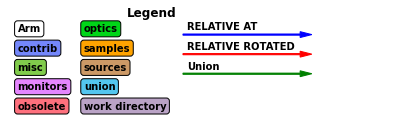

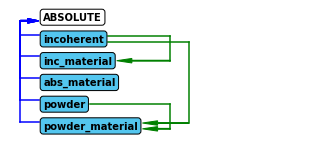

In [10]:
instrument.show_diagram()

Let us defined a quick test instrument to see these materials are behaving as expected. First we add a source.

In [11]:
src = instrument.add_component("source", "Source_div")

source_width = instrument.add_parameter("source_width", value=0.15,
                                        comment="Width of source in [m]")
src.xwidth = source_width
src.yheight = 0.03
src.focus_aw = 0.01
src.focus_ah = 0.01

src.lambda0 = instrument.add_parameter("wavelength", value=5.0,
                                       comment="Wavelength in [Ang]")
src.dlambda = "0.001*wavelength"

## Adding geometries that use the material definitions
Here we add three boxes, each using a different material definition and placed next to one another. The *material_string* parameter is used to specify the material name. The *priority* parameter will be explained later, as it is only important when geometries overlap, here they are spatially separated, yet the priorities must still be unique.

It is important to note that these three boxes will be simulated simultaneously in the McStas simulation flow, so no need for GROUP statements to have these in parallel. Because they are simulated simultaneously, a ray can go from one to another, which would not be possible with a standard GROUP.

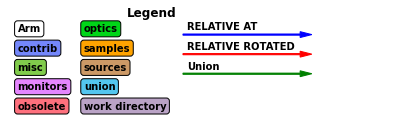

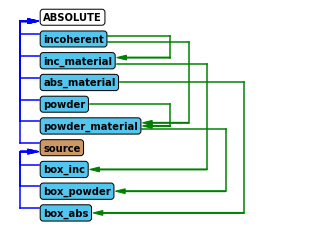

In [12]:
box_inc = instrument.add_component("box_inc", "Union_box", AT=[0.04,0,1], RELATIVE=src)
box_inc.xwidth = 0.03
box_inc.yheight = 0.03
box_inc.zdepth = 0.03
box_inc.material_string = '"inc_material"'
box_inc.priority = 10

box_inc = instrument.add_component("box_powder", "Union_box", AT=[0,0,1], RELATIVE=src)
box_inc.xwidth = 0.03
box_inc.yheight = 0.03
box_inc.zdepth = 0.01
box_inc.material_string = '"powder_material"'
box_inc.priority = 11

box_inc = instrument.add_component("box_abs", "Union_box", AT=[-0.04,0,1], RELATIVE=src)
box_inc.xwidth = 0.03
box_inc.yheight = 0.03
box_inc.zdepth = 0.03
box_inc.material_string = '"abs_material"'
box_inc.priority = 12

Let us take another look at how this changed the instrument diagram. The three geometries have been added, and each have a line to their material component. 

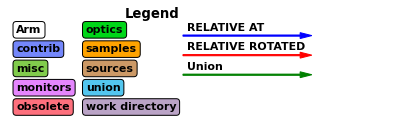

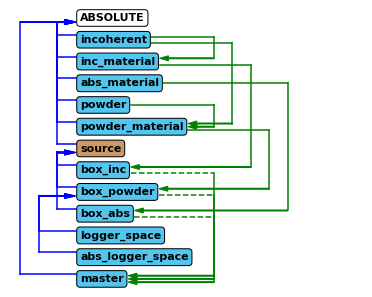

In [21]:
instrument.show_diagram()

## Adding loggers that show scattering and absorption
In order to check the three materials behave as expected, we add spatial loggers for scattering and absorption. These are called loggers and abs_loggers, here is the parameters for a logger.

In [13]:
instrument.component_help("Union_logger_2D_space")

 ___ Help Union_logger_2D_space _____________________________________________________
|optional parameter|required parameter|default value|user specified value|
target_geometry = "NULL" [string] // Comma seperated list of geometry names 
                                     that will be logged, leave empty for all 
                                     volumes (even not defined yet) 
target_process = "NULL" [string] // Comma seperated names of physical 
                                    processes, if volumes are selected, one can 
                                    select Union_process names 
D_direction_1 = "x" [string] // Direction for first axis ("x", "y" or "z")
D1_min = -5.0 [1] // histogram boundery, min position value for first axis
D1_max = 5.0 [1] // histogram boundery, max position value for first axis
n1 = 90.0 [1] // number of bins for first axis
D_direction_2 = "z" [string] // Direction for second axis ("x", "y" or "z")
D2_min = -5.0 [1] // histogram boundery, min positi

The parameters for the abs_logger are very similar, so the two are added here.

In [14]:
logger = instrument.add_component("logger_space", "Union_logger_2D_space")
logger.set_RELATIVE("box_powder")
logger.D_direction_1 = '"z"'
logger.D1_min = -0.04
logger.D1_max = 0.04
logger.n1 = 250
logger.D_direction_2 = '"x"'
logger.D2_min = -0.075
logger.D2_max = 0.075
logger.n2 = 400
logger.filename = '"logger.dat"'

logger = instrument.add_component("abs_logger_space", "Union_abs_logger_2D_space")
logger.set_RELATIVE("box_powder")
logger.D_direction_1 = '"z"'
logger.D1_min = -0.04
logger.D1_max = 0.04
logger.n1 = 250
logger.D_direction_2 = '"x"'
logger.D2_min = -0.075
logger.D2_max = 0.075
logger.n2 = 400
logger.filename = '"abs_logger.dat"'

## Adding the Union master component
The Union master component is what actually executes the simulation, and so it takes information from all Union components defined before and performs the described simulation. This is the component that matters in terms of order of execution within the sequence of McStas components. As all the previous components have described the what the master component should simulate, it has no required parameters. It also does not matter where it is located in space, as it will grab the locations described by all previous Union components that need a spatial location, such as the geometries and loggers.

In [15]:
instrument.component_help("Union_master")

 ___ Help Union_master ______________________________________________________________
|optional parameter|required parameter|default value|user specified value|
verbal = 1.0 [bool] // Toogles terminal output describing the defined simulation
list_verbal = 0.0 [bool] // Toogles information of all internal lists in 
                            intersection network 
finally_verbal = 0.0 [bool] // Toogles information about cleanup performed in 
                               finally section 
allow_inside_start = 0.0 [bool] // Set to 1 to allow rays to start inside the 
                                   defined geometry 
enable_tagging = 0.0 [bool] // Enable tagging of ray history (geometry, 
                               scattering process) 
history_limit = 300000.0 [bool] // Limit the number of unique histories that 
                                   are saved 
enable_conditionals = 1.0 [bool] // Use conditionals with this master
inherit_number_of_scattering_events = 0.0 [bool] // Inhe

In [16]:
master = instrument.add_component("master", "Union_master")

Although the Union_master component is not told specifically what geometry components to simulate, it picks up the relevant information from the components added before it. The instrument diagram shows these hidden connections.

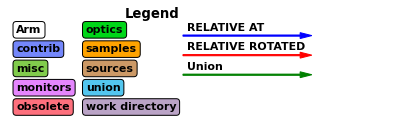

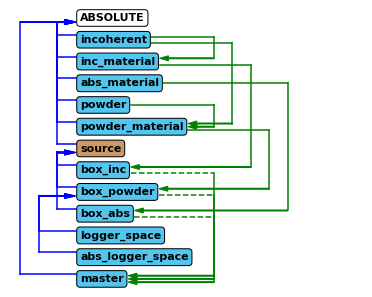

In [22]:
instrument.show_diagram()

## Running the simulation
Here the McStas simulation is executed as normal.

In [17]:
instrument.set_parameters(wavelength=8.0)
instrument.settings(ncount=3E6, output_path="data_folder/union_materials")
instrument.show_settings()

data = instrument.backengine()

Instrument settings:
  ncount:           3.00e+06
  output_path:      data_folder/union_materials
  run_path:         run_folder
  package_path:     /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1
  executable_path:  /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1/bin/
  executable:       mcrun
  force_compile:    True
INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/union_materials_45"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *,

## Interpreting the results
The first logger shows scattering, and since the top box has incoherent, and the middle both powder and incoherent, we expect those to show up. We can see the beam attenuation, as the beam originates from the left side.

The second logger shows absorption, and here the top box is absent as it has no absorption cross section. The bottom box is however visible now, as it has absorption but no scattering. As the absorber is quite strong, we see the attenuation here as well.

Plotting data with name logger_space
Plotting data with name abs_logger_space


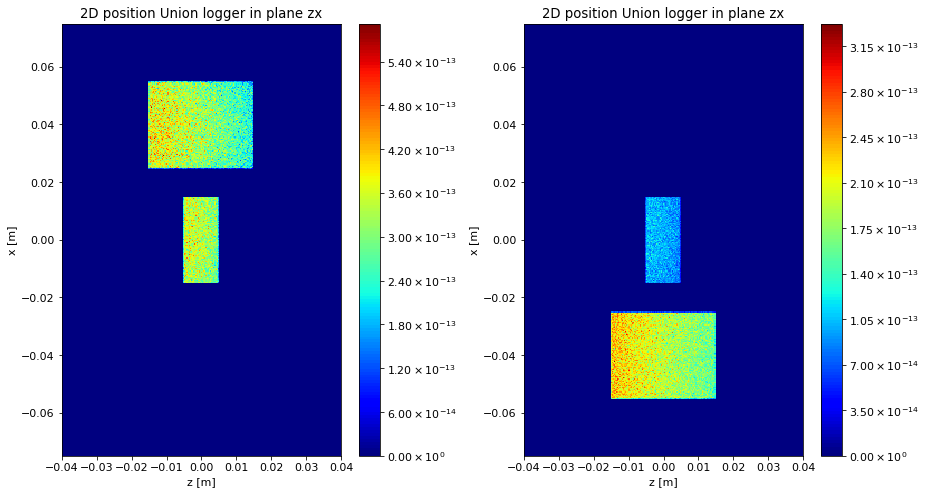

In [18]:
ms.make_sub_plot(data)

### Alternative run to show powder properties
In order to see the scattering from the powder sample, we restrict the source size to only illuminate the center box with a powder material. A wavelength with powder lines close to 90 deg is selected to ensure the scattering from the center box hits the surrounding boxes.

We choose to show the data with logarithmic colorscale using the *name_plot_options* method on functions.

In [19]:
instrument.set_parameters(wavelength=2.8, source_width=0.03)
instrument.settings(ncount=5E6, output_path="data_folder/union_materials")
instrument.show_settings()

data = instrument.backengine()

Instrument settings:
  ncount:           5.00e+06
  output_path:      data_folder/union_materials
  run_path:         run_folder
  package_path:     /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1
  executable_path:  /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1/bin/
  executable:       mcrun
  force_compile:    True
INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/union_materials_46"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *,

Plotting data with name logger_space
Plotting data with name abs_logger_space


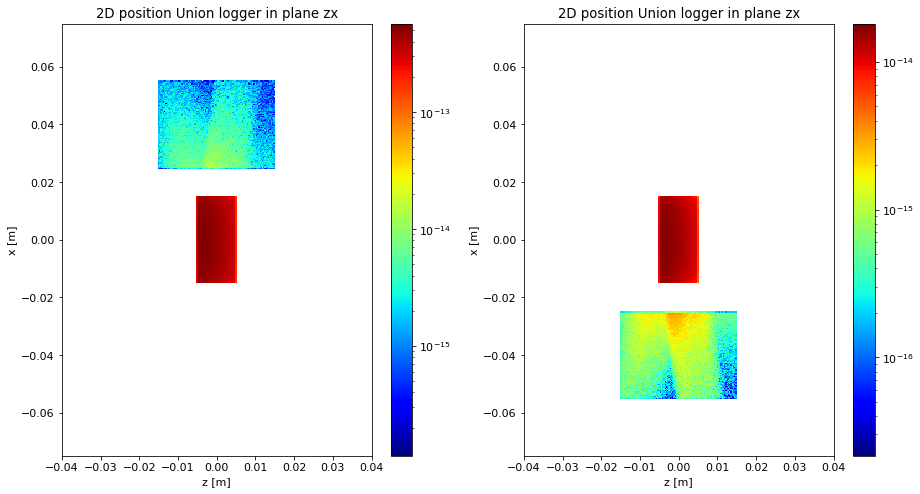

In [20]:
ms.name_plot_options("logger_space", data, log=True)
ms.name_plot_options("abs_logger_space", data, log=True)
ms.make_sub_plot(data)

### Interpretation of the data
Now that the direct beam only hits the center box, all rays that enter the surrounding boxes are scattered from that center box. Since the center box contains a powder, the scattered beam is not homogeneous and most of it is in the form of Bragg peaks with certain scattering angles, and we can see two of these intersecting the surrounding geometries.

### Troubleshooting
In case of issues with the notebooks concerning the Union components or McStasScript it is recommended to:
- Update McStasScript with python -m pip install --upgrade mcstasscript
- Get newest version of Union components (Both library files and components themselves)

Since the Union components need to collaborate, it is important to have the same version of the libraries and components. The newest version of the components can be found here: https://github.com/McStasMcXtrace/McCode/tree/master/mcstas-comps/contrib/union
All libraries for McStas are found here: https://github.com/McStasMcXtrace/McCode/tree/master/mcstas-comps/share but only a few are needed for the Union components:
- Union_initialization.c
- Union_functions.c
- Geometry_functions.c
- Union_last_functions.c (if on McStas 3.X)